In [1]:
import tensorflow as tf
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio
%matplotlib notebook
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# 网络框架的编写

In [2]:
def get_weights(layers, i):
    weight = layers[i][0][0][0][0][0]
    weight = tf.constant(weight)
    return weight

In [3]:
def get_biases(layers, i):
    b = layers[i][0][0][0][0][1]
    b = tf.constant(b)
    return b

In [4]:
def conv_layer(X, W):
    conv = tf.nn.conv2d(X, filter=W, strides=[1, 1, 1, 1], padding='SAME')
    return conv

In [5]:
def relu_layer(X, b):
    relu = tf.nn.relu(X + b)
    return relu

In [6]:
def pool_layer(X, pool_type='avg'):
    if pool_type == 'avg':
        pool = tf.nn.avg_pool(X, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    elif pool_type == 'max':
        pool = tf.nn.max_pool(X, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    return pool

In [7]:
def build_model(input_img):
    net = {}
    _, h, w, d = input_img.shape
    vgg_rawnet = sio.loadmat('vgg-models/imagenet-vgg-verydeep-19.mat')
    vgg_layers = vgg_rawnet['layers'][0]
    
    net['input'] = tf.Variable(np.zeros([1, h, w, d]), dtype=tf.float32)
    
    net['conv1_1'] = conv_layer(net['input'], W=get_weights(vgg_layers, 0))
    net['relu1_1'] = relu_layer(net['conv1_1'], b=get_biases(vgg_layers, 0))
    
    net['conv1_2'] = conv_layer(net['relu1_1'], W=get_weights(vgg_layers, 2))
    net['relu1_2'] = relu_layer(net['conv1_2'], b=get_biases(vgg_layers, 2))
    
    net['pool1'] = pool_layer(net['relu1_2'])
    
    net['conv2_1'] = conv_layer(net['pool1'], W=get_weights(vgg_layers, 5))
    net['relu2_1'] = relu_layer(net['conv2_1'], b=get_biases(vgg_layers, 5))
    
    net['conv2_2'] = conv_layer(net['relu2_1'], W=get_weights(vgg_layers, 7))
    net['relu2_2'] = relu_layer(net['conv2_2'], b=get_biases(vgg_layers, 7))
    
    net['pool2'] = pool_layer(net['relu2_2'])
    
    net['conv3_1'] = conv_layer(net['pool2'], W=get_weights(vgg_layers, 10))
    net['relu3_1'] = relu_layer(net['conv3_1'], b=get_biases(vgg_layers, 10))

    net['conv3_2'] = conv_layer(net['relu3_1'], W=get_weights(vgg_layers, 12))
    net['relu3_2'] = relu_layer(net['conv3_2'], b=get_biases(vgg_layers, 12))

    net['conv3_3'] = conv_layer(net['relu3_2'], W=get_weights(vgg_layers, 14))
    net['relu3_3'] = relu_layer(net['conv3_3'], b=get_biases(vgg_layers, 14))

    net['conv3_4'] = conv_layer(net['relu3_3'], W=get_weights(vgg_layers, 16))
    net['relu3_4'] = relu_layer(net['conv3_4'], b=get_biases(vgg_layers, 16))
    
    net['pool3']   = pool_layer(net['relu3_4'])

    net['conv4_1'] = conv_layer(net['pool3'], W=get_weights(vgg_layers, 19))
    net['relu4_1'] = relu_layer(net['conv4_1'], b=get_biases(vgg_layers, 19))

    net['conv4_2'] = conv_layer(net['relu4_1'], W=get_weights(vgg_layers, 21))
    net['relu4_2'] = relu_layer(net['conv4_2'], b=get_biases(vgg_layers, 21))
    
    net['conv4_3'] = conv_layer(net['relu4_2'], W=get_weights(vgg_layers, 23))
    net['relu4_3'] = relu_layer(net['conv4_3'], b=get_biases(vgg_layers, 23))

    net['conv4_4'] = conv_layer(net['relu4_3'], W=get_weights(vgg_layers, 25))
    net['relu4_4'] = relu_layer(net['conv4_4'], b=get_biases(vgg_layers, 25))

    net['pool4']   = pool_layer(net['relu4_4'])
    
    net['conv5_1'] = conv_layer(net['pool4'], W=get_weights(vgg_layers, 28))
    net['relu5_1'] = relu_layer(net['conv5_1'], b=get_biases(vgg_layers, 28))

    net['conv5_2'] = conv_layer(net['relu5_1'], W=get_weights(vgg_layers, 30))
    net['relu5_2'] = relu_layer(net['conv5_2'], b=get_biases(vgg_layers, 30))

    net['conv5_3'] = conv_layer(net['relu5_2'], W=get_weights(vgg_layers, 32))
    net['relu5_3'] = relu_layer(net['conv5_3'], b=get_biases(vgg_layers, 32))

    net['conv5_4'] = conv_layer(net['relu5_3'], W=get_weights(vgg_layers, 34))
    net['relu5_4'] = relu_layer(net['conv5_4'], b=get_biases(vgg_layers, 34))

    net['pool5']   = pool_layer(net['relu5_4'])
    
    return net

In [8]:
def gram_matrix(a, area, depth):
    F = tf.reshape(a, [area, depth])
    G = tf.matmul(tf.transpose(F), F)
    return G

In [9]:
def style_loss(a, x):
    _, h, w, d = a.get_shape()
    M = h.value * w.value
    N = d.value
    A = gram_matrix(a, M, N)
    G = gram_matrix(x, M, N)
    loss = 1.0 / (4 * N**2 * M**2) * (tf.reduce_mean(tf.pow((A - G), 2)))
    return loss

In [10]:
def sum_style_loss(sess, net, style_img, style_layers, style_weights):
    sess.run(net['input'].assign(style_img))
    loss = 0.0
    for layer, weight in zip(style_layers, style_weights):
        a = sess.run(net[layer])
        x = net[layer]
        a = tf.convert_to_tensor(a)
        loss += style_loss(a, x) * weight
    loss /= float(len(style_layers))
    return loss

In [11]:
def content_loss(p, x):
    loss = 1.0 / 2.0 * tf.reduce_mean(tf.pow((p - x), 2))
    return loss

In [12]:
def sum_content_loss(sess, net, content_img, content_layers, content_weights):
    sess.run(net['input'].assign(content_img))
    loss = 0.0
    for layer, weight in zip(content_layers, content_weights):
        p = sess.run(net[layer])
        x = net[layer]
        p = tf.convert_to_tensor(p)
        loss += content_loss(p, x) * weight
    loss /= float(len(content_layers))
    return loss

In [37]:
def stylize(init_img, content_img, style_img):
    with tf.Session() as sess:
        
        net = build_model(content_img)
        STYLE_LAYERS = ['relu1_1', 'relu2_1', 'relu3_1', 'relu4_1', 'relu5_1']
        CONTENT_LAYERS = ['conv4_2']
        STYLE_WEIGHTS = [0.2, 0.2, 0.2, 0.2, 0.2]
        CONTENT_WEIGHTS = [1.0]
        ALPHA = 5
        BETA = 2000000
        THETA = 0.003
        
        L_style = sum_style_loss(sess, net, style_img, STYLE_LAYERS, STYLE_WEIGHTS)
        L_content = sum_content_loss(sess, net, content_img, CONTENT_LAYERS, CONTENT_WEIGHTS)
        L_tv = tf.image.total_variation(net['input'])
        
        L_total = BETA * L_style + ALPHA * L_content + THETA * L_tv
        
        optimizer = tf.contrib.opt.ScipyOptimizerInterface(
            loss=L_total, method='L-BFGS-B',
            options={'maxiter': 8000,
                     'disp': 50})
        init = tf.global_variables_initializer()
        sess.run(init)
        sess.run(net['input'].assign(init_img))
        optimizer.minimize(sess)
        
        output_img = sess.run(net['input'])
        return output_img

# 图像的读写、预处理

In [14]:
def preprocess(img):
    img = img[...,::-1]
    img = img[np.newaxis, :, :, :]
    IMAGE_MEANS = np.array([123.68, 116.779, 103.939]).reshape([1, 1, 1, 3])
    img -= IMAGE_MEANS
    return img

In [15]:
def postprocess(img):
    IMAGE_MEANS = np.array([123.68, 116.779, 103.939]).reshape([1, 1, 1, 3])
    img += IMAGE_MEANS
    img = img[0]
    img = np.clip(img, 0, 255).astype(np.uint8)
    return img

In [16]:
def read_img(path):
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    img = img.astype(np.float32)
    img = preprocess(img)
    return img

In [17]:
def get_content_image(path, MaxSize=512):
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    img = img.astype(np.float32)
    h, w, d = img.shape
    if h > w and h > MaxSize:
        w = (float(MaxSize) / h) * w
        img = cv2.resize(img, dsize=(int(w), MaxSize), interpolation=cv2.INTER_AREA)
    if w > MaxSize:
        h = (float(MaxSize) / w) * h
        img = cv2.resize(img, dsize=(MaxSize, int(h)), interpolation=cv2.INTER_AREA)
    img = preprocess(img)
    return img

In [18]:
def get_style_image(path, content_img):
    _, ch, cw, cd = content_img.shape
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    img = img.astype(np.float32)
    img = cv2.resize(img, dsize=(cw, ch), interpolation=cv2.INTER_AREA)
    img = preprocess(img)
    return img

In [19]:
def get_plot_img(data):
    img = postprocess(data)
    return img

In [20]:
def convert_to_original_colors(content_img, stylized_img, color_convert_type='yuv'):
    content_img = postprocess(content_img)
    stylized_img = postprocess(stylized_img)
    if color_convert_type == 'yuv':
        cvt_type = cv2.COLOR_BGR2YUV
        inv_cvt_type = cv2.COLOR_YUV2BGR
    elif color_convert_type == 'ycrcb':
        cvt_type = cv2.COLOR_BGR2YCR_CB
        inv_cvt_type = cv2.COLOR_YCR_CB2BGR
    elif color_convert_type == 'luv':
        cvt_type = cv2.COLOR_BGR2LUV
        inv_cvt_type = cv2.COLOR_LUV2BGR
    elif color_convert_type == 'lab':
        cvt_type = cv2.COLOR_BGR2LAB
        inv_cvt_type = cv2.COLOR_LAB2BGR
    content_cvt = cv2.cvtColor(content_img, cvt_type)
    stylized_cvt = cv2.cvtColor(stylized_img, cvt_type)
    c1, _, _ = cv2.split(stylized_cvt)
    _, c2, c3 = cv2.split(content_cvt)
    merged = cv2.merge((c1, c2, c3))
    return merged

In [38]:
content_file = 'image_input/Bing.jpg'
style_file = 'styles/the_scream.jpg'
content_img = get_content_image(content_file)
style_img = get_style_image(style_file, content_img)
out_img = stylize(content_img, content_img, style_img)

INFO:tensorflow:Optimization terminated with:
  Message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  Objective function value: 574683.750000
  Number of iterations: 7019
  Number of functions evaluations: 7297


In [35]:
img = get_plot_img(out_img)

<IPython.core.display.Javascript object>


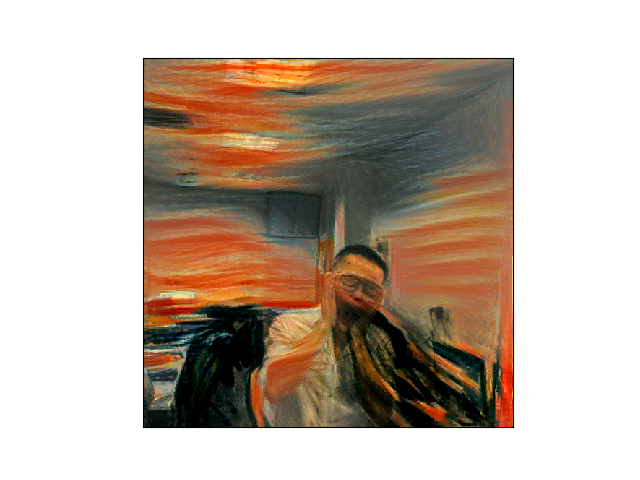

([], <a list of 0 Text xticklabel objects>)

([], <a list of 0 Text yticklabel objects>)

In [36]:
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.show()

In [62]:
content_img.shape

(1, 711, 1024, 3)

In [46]:
a = convert_to_original_colors(np.copy(content_img) ,out_img)

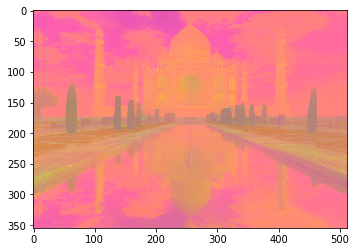

In [47]:
plt.imshow(a)
plt.show()